# Task 1

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
# Enable autoreloading if import packages are changed
%load_ext autoreload
%autoreload 2

In [3]:
# Set up python path
import sys
import os
import cv2
import numpy as np
import torch
import math
import glob
import cv2 as cv
from math import sin, cos
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load images and keypoints

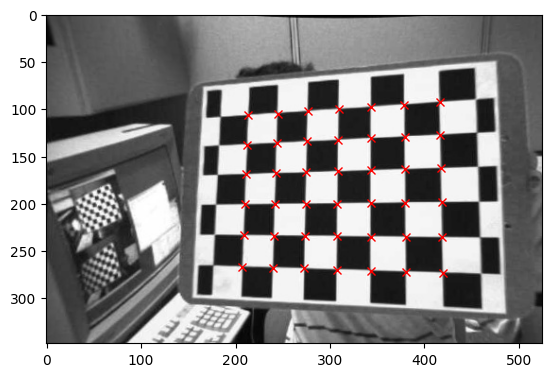

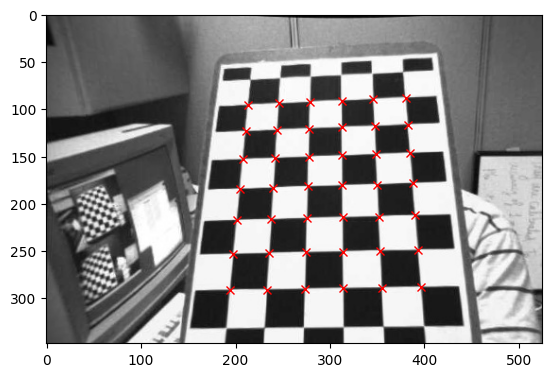

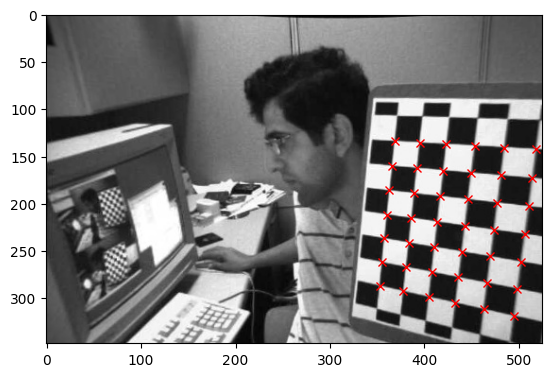

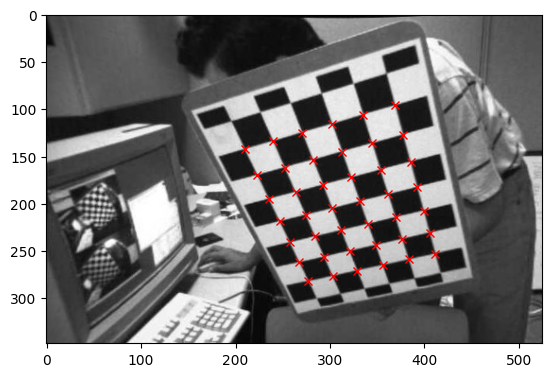

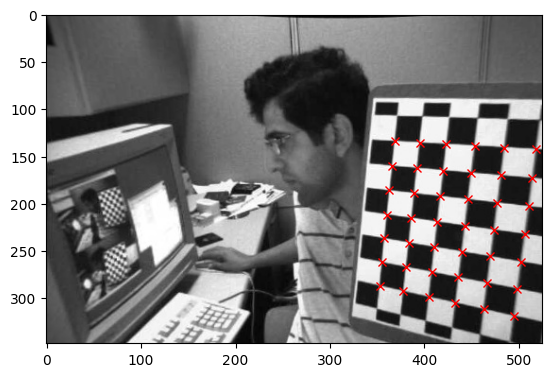

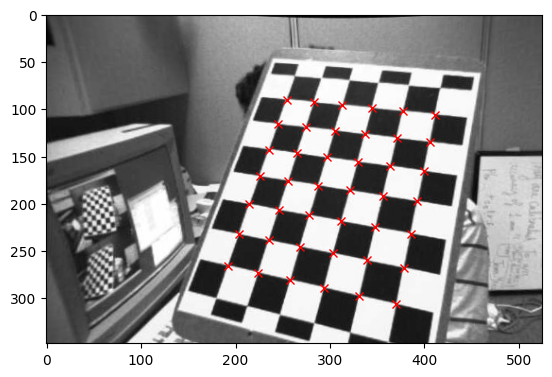

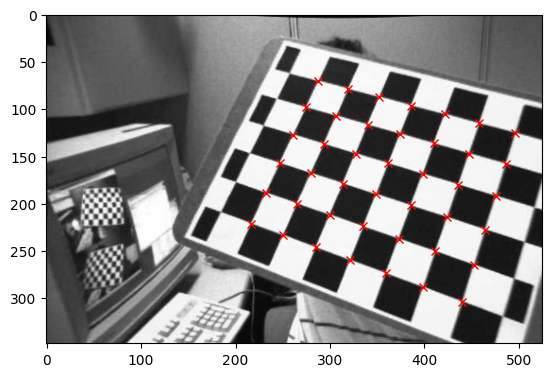

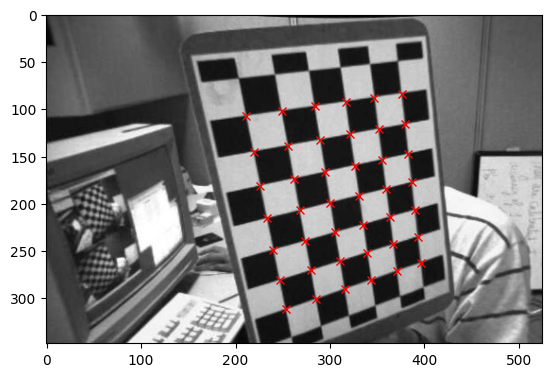

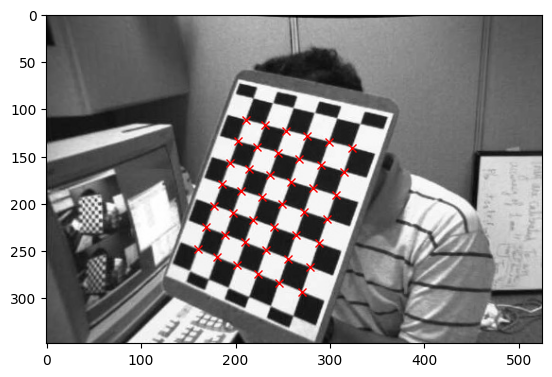

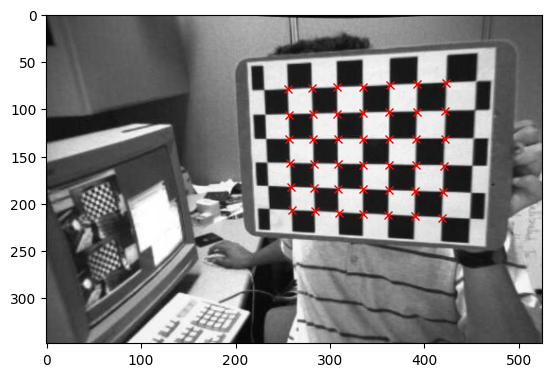

In [4]:
# Load images and keypoints
images_ = []
keypoints = []
for fname in glob.glob('./images/*.jpg'):
    kps = np.loadtxt(fname.replace('.jpg', '-keypoints.txt'))
    keypoints.append(kps)
    img = cv.imread(fname)
    images_.append(img)

    plt.figure()
    plt.imshow(img)
    plt.plot(kps[:, 0], kps[:,1], 'rx')

# Prepare 3D object points of checker board like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objpoints = np.zeros((6*7,3), np.float32)
objpoints[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

## Q1 (Bonus): Normalize 2D and 3D points

In [5]:
keypoints = np.array(keypoints)
T_matrix = []
mean_ = np.mean(keypoints, axis =1)

norm_keypoints = []

for index,keypoint in enumerate(keypoints):
  ones_array = np.ones((np.array(keypoints)[index].shape[0], 1), dtype=np.array(keypoints)[index].dtype)
  result_array = np.hstack((np.array(keypoints)[index], ones_array))

  distances = np.mean(np.linalg.norm(keypoints[index] - np.mean(keypoints[index], axis=0), axis=1))


  norm_kp_T = [[1/ distances *np.sqrt(2) , 0 , -mean_[index][0]/ distances * np.sqrt(2)], [0 ,1/ distances* np.sqrt(2)  , -mean_[index][1] / distances * np.sqrt(2)] , [0 ,0 , 1] ]
  T_matrix.append(norm_kp_T)
  norm_keypoints.append(np.matmul(norm_kp_T, result_array.T).T)


In [6]:
mean__ = np.mean(objpoints, axis = 0)

ones_array = np.ones((objpoints.shape[0], 1), dtype=objpoints.dtype)
result_array = np.hstack((objpoints[: ,0:2], ones_array))

distances = np.mean(np.linalg.norm(objpoints - np.mean(objpoints, axis=0), axis=1))

norm_op_T = [[1/ distances * np.sqrt(3) , 0 , -mean__[0]/ distances* np.sqrt(3)], [0 ,1/ distances* np.sqrt(3)  , -mean__[1] / distances* np.sqrt(3)] , [0 ,0 , 1] ]
norm_objpoints = np.matmul(norm_op_T, result_array.T).T
#norm_objpoints = np.hstack((norm_objpoints[: ,0:2], np.zeros((norm_objpoints.shape[0], 1), dtype=(norm_objpoints).dtype)))

## Q2: Compute homography for each image

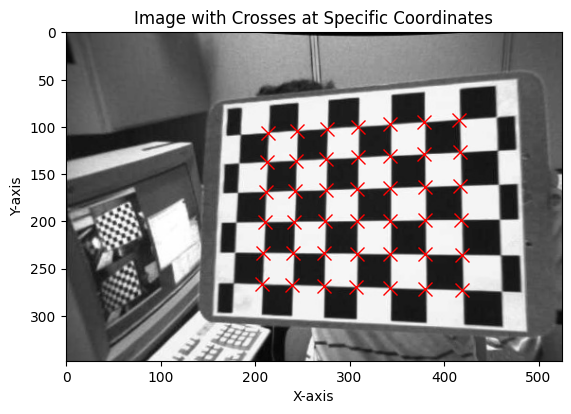

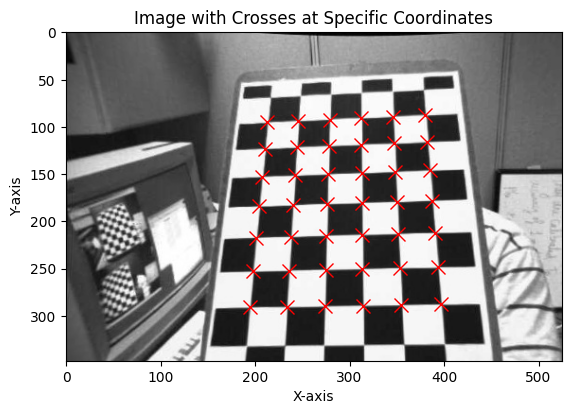

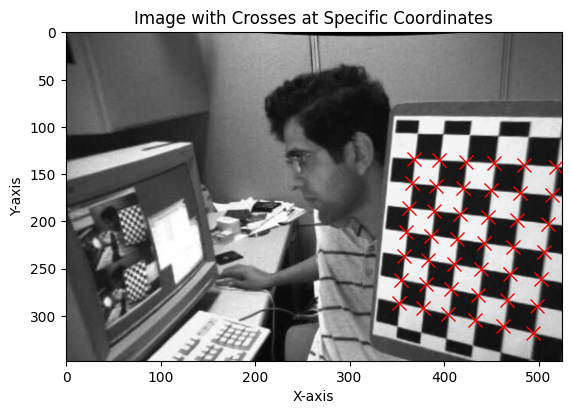

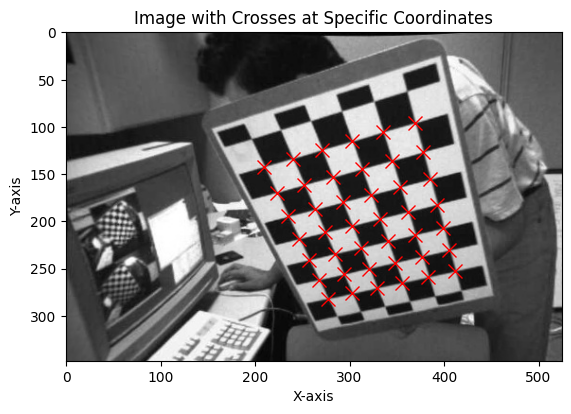

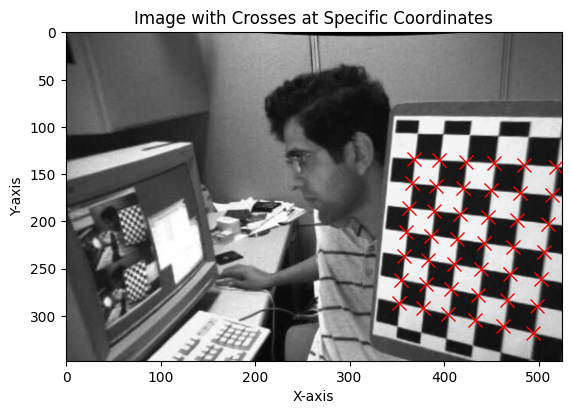

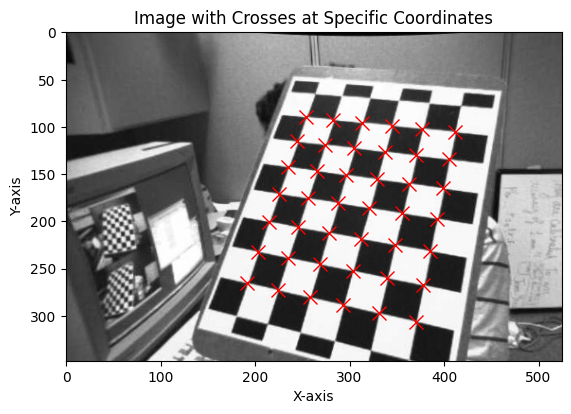

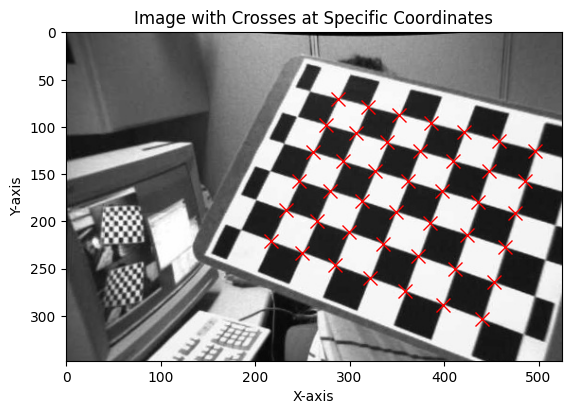

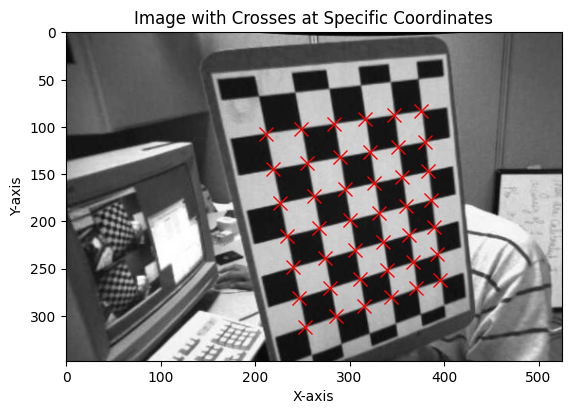

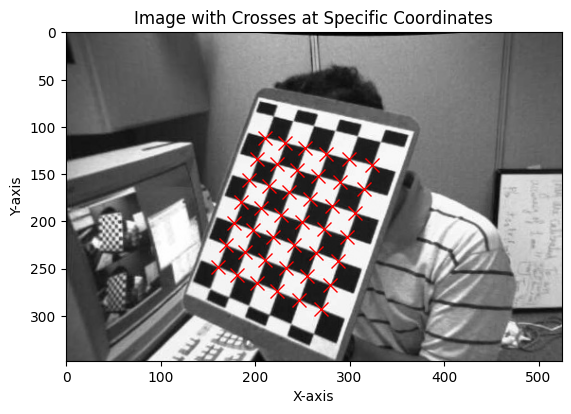

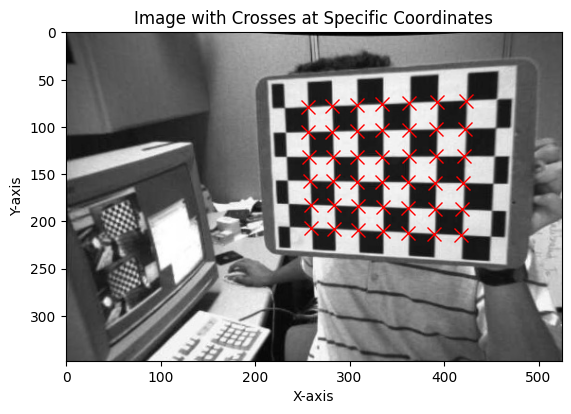

In [7]:
# Compute homographies
# See slide 21 of Lecture 4 Part B

N = objpoints.shape[0] # Number of points
homographies = [] # Computed homographies

for images in range(10):
  A = []
  for i in range(N):
    A.append([0,0,0, -norm_objpoints[i , 0], -norm_objpoints[i , 1], -1, norm_keypoints[images][i , 1]* norm_objpoints[i , 0] , norm_keypoints[images][i , 1]* norm_objpoints[i , 1],norm_keypoints[images][i , 1]  ])
    A.append([norm_objpoints[i , 0],norm_objpoints[i , 1],1, 0,0,0, -norm_keypoints[images][i , 0]* norm_objpoints[i , 0] ,-norm_keypoints[images][i , 0]* norm_objpoints[i , 1] , -norm_keypoints[images][i , 0]   ])
  A = np.array(A)
  # Perform SVD on A
  U, S, Vt = np.linalg.svd(A)

  # The solution vector x is the last column of V (the right singular vector corresponding to the smallest singular value)
  x = Vt[-1, :].reshape(3,3)
  homographies.append(np.matmul(np.linalg.inv(T_matrix[images]) ,np.matmul(x, norm_op_T)))

# Check your homographies by taking the object points and projecting them to the images


for i in range(len(images_)):

    points = np.matmul(homographies[i], np.hstack((objpoints[: ,0:2], ones_array)).T).T
    points = np.divide(points[:, :2], points[:, 2].reshape(-1, 1))

    img = images_[i]
    # Plot the image
    fig, ax = plt.subplots()
    ax.imshow(img)

    # Plot crosses at the specified coordinates
    for coord in points:
        x, y = coord[0], coord[1]
        ax.plot(x, y, 'rx', markersize=10)  # 'rx' denotes a red cross

    # Add labels and title
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title('Image with Crosses at Specific Coordinates')

    # Display the plot
    plt.show()




## Q3: Compute calibration matrix and extrinsics

In [8]:
# Compute matrix B
# (see slide 25 of Lecture 4 Part B)
A = []
for images in range(10):
    m= 0;
    n =1;
    A.append([homographies[images][m,0]*  homographies[images][n,0] , homographies[images][m,0]*  homographies[images][n,1] + homographies[images][m,1]*  homographies[images][n,0] , homographies[images][m,1]*  homographies[images][n,1], homographies[images][m,2]*  homographies[images][n,0] + homographies[images][m,0]*  homographies[images][n,2] ,homographies[images][m,2]*  homographies[images][n,1] + homographies[images][m,1]*  homographies[images][n,2]  , homographies[images][m,2]*  homographies[images][n,2] ])
    m=0;
    n=0;
    a_p = [homographies[images][m,0]*  homographies[images][n,0] , homographies[images][m,0]*  homographies[images][n,1] + homographies[images][m,1]*  homographies[images][n,0] , homographies[images][m,1]*  homographies[images][n,1], homographies[images][m,2]*  homographies[images][n,0] + homographies[images][m,0]*  homographies[images][n,2] ,homographies[images][m,2]*  homographies[images][n,1] + homographies[images][m,1]*  homographies[images][n,2]  , homographies[images][m,2]*  homographies[images][n,2] ]
    m=1;
    n=1;
    a_pp = [homographies[images][m,0]*  homographies[images][n,0] , homographies[images][m,0]*  homographies[images][n,1] + homographies[images][m,1]*  homographies[images][n,0] , homographies[images][m,1]*  homographies[images][n,1], homographies[images][m,2]*  homographies[images][n,0] + homographies[images][m,0]*  homographies[images][n,2] ,homographies[images][m,2]*  homographies[images][n,1] + homographies[images][m,1]*  homographies[images][n,2]  , homographies[images][m,2]*  homographies[images][n,2] ]
    A.append([a - b for a, b in zip(a_p, a_pp)])

# Perform SVD on A
U, S, Vt = np.linalg.svd(A)
# The solution vector x is the last column of V (the right singular vector corresponding to the smallest singular value)
B_matrix = (Vt[-1, :])



# Compute K
# (see slide 26 of Lecture 4 Part B)
# Hint: the first row of K should be: 24.69157096, 5.41685322, -20.44468869
# Hint: don't forget to normalize to have the lower right entry to be 1

b11 ,b12,b22,b13,b23,b33 = B_matrix
oy = (b12*b13 - b11*b23)/(b11*b22 - b12*b12)
lambda_ = b33 - (b13*b13 + oy*(b12*b13 - b11*b23))/b11
cx = np.sqrt(lambda_/b11)
cy = np.sqrt(lambda_ * b11/(b11*b22 - b12*b12))
tau = -b12*cx*cx*cy/lambda_
ox = tau*oy/cy - b12*cx*cx/lambda_

K = np.array([[cx/lambda_, tau/lambda_, ox/lambda_], [0, cy/lambda_, oy/lambda_], [0,0,1]])

print('K:')
print(K)

# Compute extrinsics and projection matrices
# (see slide 27 of Lecture 4 Part B)
#it is shown in the next cell


K:
[[-24.33155781  -5.55542005 -68.31460374]
 [  0.         -46.15177488  -3.396144  ]
 [  0.           0.           1.        ]]


## Q4: Project 3D points and compute error to original keypoints

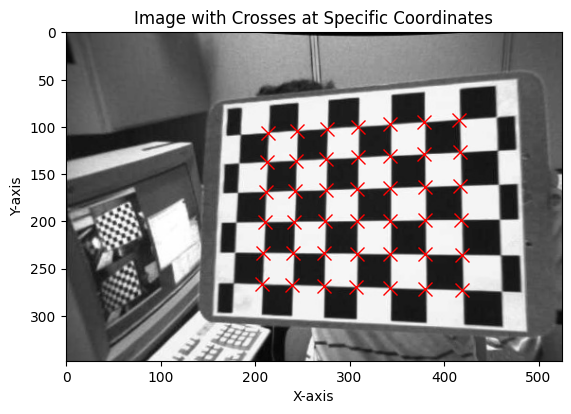

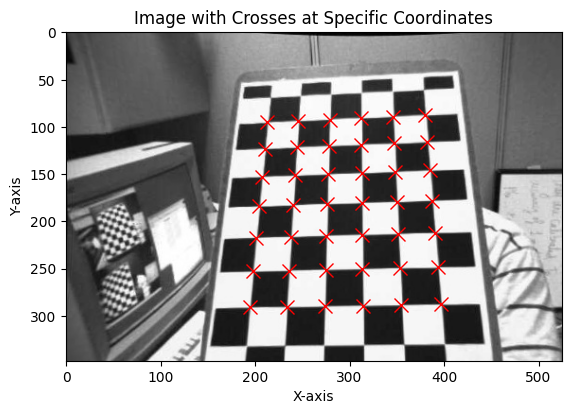

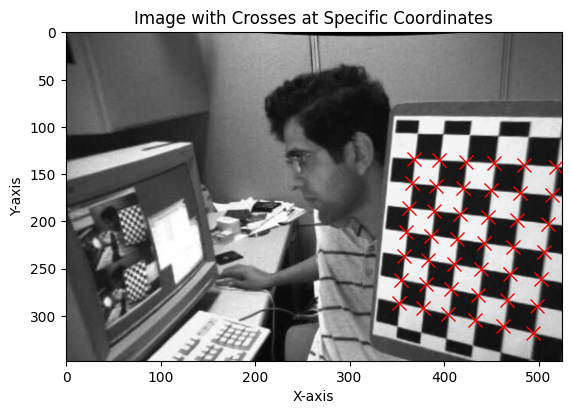

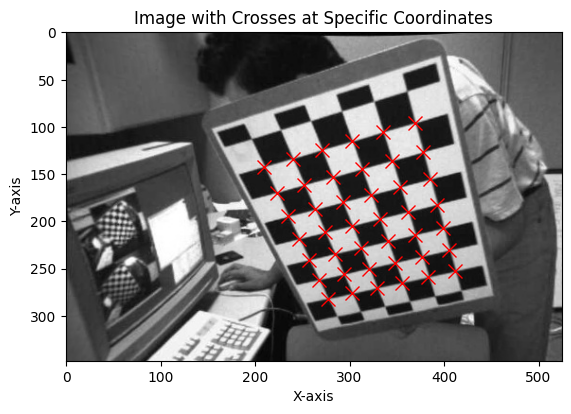

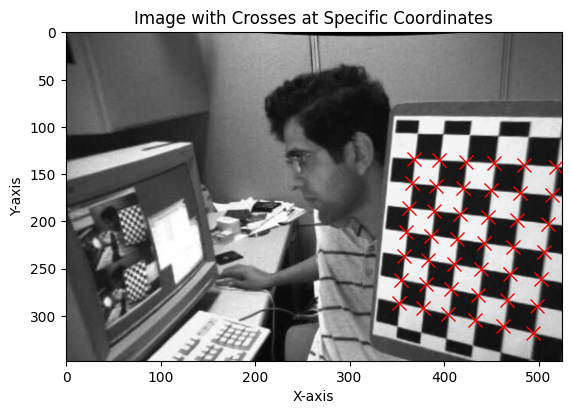

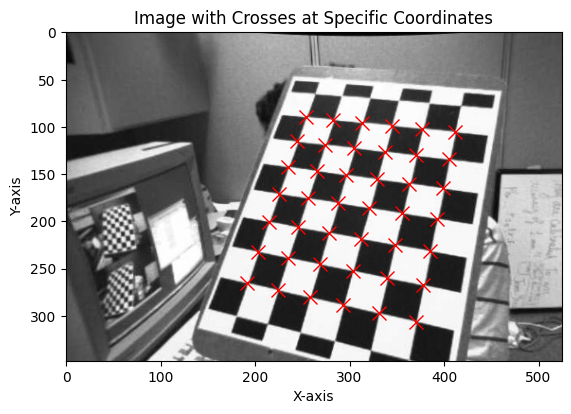

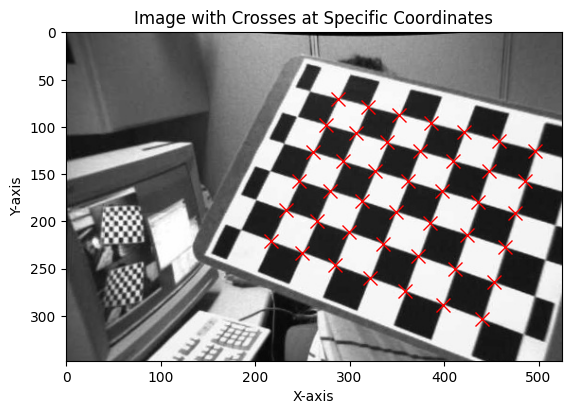

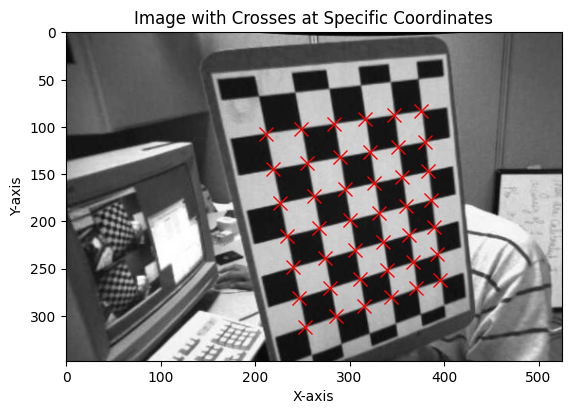

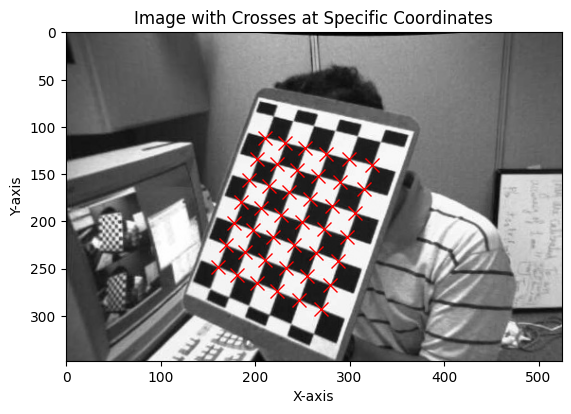

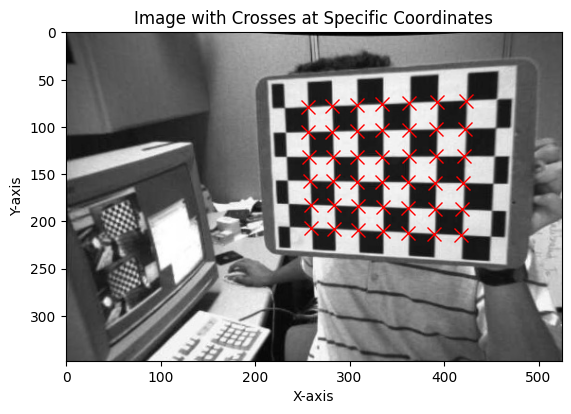

overall error: 0.1098872787626042


In [11]:
# Project object points for all images using K and respective extrinsics
# Visualize and commpute average error of projections to orignal keypoints

errors = []
objpoints = np.hstack((objpoints[: ,0:3], np.ones((objpoints.shape[0], 1))))
for i in range(10):
  ita = 1/np.linalg.norm(np.matmul(np.linalg.inv(K), homographies[i][: , 0]))
  r1 = ita* np.matmul(np.linalg.inv(K), homographies[i][: , 0])
  r2 = ita* np.matmul(np.linalg.inv(K), homographies[i][: , 1])
  r3 = np.cross(r1,r2)
  t = ita* np.matmul(np.linalg.inv(K), homographies[i][: , 2])

  #Extrinsic Matrix:-
  extrinsic_matrix = np.hstack((r1.reshape(-1, 1), r2.reshape(-1, 1), r3.reshape(-1, 1), t.reshape(-1, 1)))

  #Projection Matrix
  projection_matrix = np.matmul(K,extrinsic_matrix)
  points = (np.matmul(projection_matrix, objpoints.T).T)
  points = np.divide(points[:, :2], points[:, 2].reshape(-1, 1))

  img = images_[i]
  fig, ax = plt.subplots()
  ax.imshow(img)

  # Plot crosses at the specified coordinates
  for coord in points:
        x, y = coord[0], coord[1]
        ax.plot(x, y, 'rx', markersize=10)  # 'rx' denotes a red cross

  # Add labels and title
  ax.set_xlabel('X-axis')
  ax.set_ylabel('Y-axis')
  ax.set_title('Image with Crosses at Specific Coordinates')

  # Display the plot
  plt.show()
  errors.append(np.linalg.norm(keypoints[i] - points, axis=1))



print('overall error:', np.mean(np.array(errors)))